# **<center>Modeling and Forecasting 5-day Rolling Returns of HIDCL Index Using ARIMA</center>**

---

## Libraries and Basic Functions



In [1]:
# Importing necessary libraries
!pip install -qq numpy==1.24.4
!pip install -qq pmdarima==2.0.3
!pip install -qq arch
!pip install -qq ta

import ta
from pmdarima.arima import auto_arima
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
from arch.unitroot import ADF
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.stats.stattools import jarque_bera
from sklearn.model_selection import TimeSeriesSplit
import scipy.stats as scs
from tabulate import tabulate
from google.colab import files

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
def plot_single_plot(data, ylabel, fig_title):
    """
    Plots a time series graph with improved formatting.

    Args:
        data: Pandas DataFrame with a Datetime or Period index and a single column.
        ylabel: Label for the y-axis.
        fig_title: Title of the plot.
    """
    # Convert PeriodIndex to DatetimeIndex if needed
    if isinstance(data.index, pd.PeriodIndex):
        data = data.copy()
        data.index = data.index.to_timestamp()

    # Set figure size
    plt.figure(figsize=(15, 6))

    # Plot the time series
    plt.plot(
        data.index,
        data,
        linestyle="-",
        linewidth=0.8
    )

    # Set labels and title
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(fig_title)

    # Format x-axis date labels for better readability
    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

    # Add grid
    plt.grid(True, linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

def acf_plot(y, lags=20, figsize=(12, 6), style='bmh', title='ACF and PACF Plots'):
    """
    Plots ACF and PACF side-by-side for a given series.

    Parameters:
    - y: pandas Series or array-like
    - lags: Number of lags to use in ACF and PACF (default: 20)
    - figsize: Size of the figure (default: (12, 4))
    - style: Matplotlib style (default: 'bmh')
    - title: Title for the figure
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(title, fontsize=14)

        smt.graphics.plot_acf(y, lags=lags, ax=axes[0], alpha=0.05)
        axes[0].set_title("Autocorrelation (ACF)")

        smt.graphics.plot_pacf(y, lags=lags, ax=axes[1], alpha=0.05)
        axes[1].set_title("Partial Autocorrelation (PACF)")

        plt.tight_layout()  # Adjust layout to fit the title
        plt.show()

    return

def plot_histogram_qq(data, title_prefix=''):
    """
    Creates a subplot with a histogram and Q-Q plot for a given dataset.

    Args:
        data (array-like): The data to plot (e.g., residuals).
        title_prefix (str): Optional prefix for subplot titles.
    """
    plt.figure(figsize=(12, 6))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of{title_prefix}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of{title_prefix}')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def adf(data, trend='n', method='bic'):
  adf_result = ADF(data, trend=trend, method=method)  # Perform ADF test on the data
  print('Augmented Dickey-Fuller Unit Root Test:\n')  # Print test statistics and critical values
  return adf_result  # Return the result of the ADF test

## 1. Data

### A. Data Collection



In [3]:
# Upload the file to Google Colab
uploaded = files. upload()

Saving HIDCL.csv to HIDCL.csv


In [49]:
# Read the file
df = pd.read_csv('HIDCL.csv')

# Drop columns
df.drop(['Symbol', 'Percent Change'], axis=1, inplace=True)

# Convert 'Date' to datetime and sort just in case
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.sort_values('Date')

# Convert 'Volume' to float (remove commas)
df['Volume'] = df['Volume'].str.replace(',', '', regex=False).astype(float)

# Return
df['Return'] = df['Close'].pct_change()*100

# Apply a rolling 5-day window over daily returns
df['Rolling_avg_5_day_return'] = df['Return'].rolling(window=5).mean()

# Drop nan
df = df.dropna()

# Daily frequency without using asfreq: https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.to_period.html
df.index = df.index.to_period("D")

### B. Technical Indicators


In [50]:
# Bollinger Bands (20-period SMA, 2 std dev)
bb = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['bb_upper'] = bb.bollinger_hband()
df['bb_lower'] = bb.bollinger_lband()
df['bb_middle'] = bb.bollinger_mavg()

# Calculate Stochastic Oscillator (3,3)
stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=14, smooth_window=3)
df['stoch_k'] = stoch.stoch()
df['stoch_d'] = stoch.stoch_signal()

# Clean NaNs
df = df.dropna()
print(df.head())

             Open   High    Low  Close   Volume    Return  \
Date                                                        
2020-07-29  129.0  131.0  129.0  129.0  14209.0 -1.526718   
2020-07-30  128.0  135.0  128.0  130.0  10681.0  0.775194   
2020-08-02  130.0  130.0  128.0  129.0  15767.0 -0.769231   
2020-08-03  128.0  130.0  128.0  129.0   7388.0  0.000000   
2020-08-05  129.0  130.0  127.0  128.0   9200.0 -0.775194   

            Rolling_avg_5_day_return    bb_upper    bb_lower  bb_middle  \
Date                                                                      
2020-07-29                 -0.453371  139.140111  121.959889     130.55   
2020-07-30                  0.004698  137.546093  124.753907     131.15   
2020-08-02                 -0.302994  136.759426  126.140574     131.45   
2020-08-03                 -0.455666  136.696152  126.303848     131.50   
2020-08-05                 -0.459190  136.298786  126.001214     131.15   

              stoch_k    stoch_d  
Date       

### C. Anomalies Detection With Z-scores

Reference: https://medium.com/@akashsri306/detecting-anomalies-with-z-scores-a-practical-approach-2f9a0f27458d

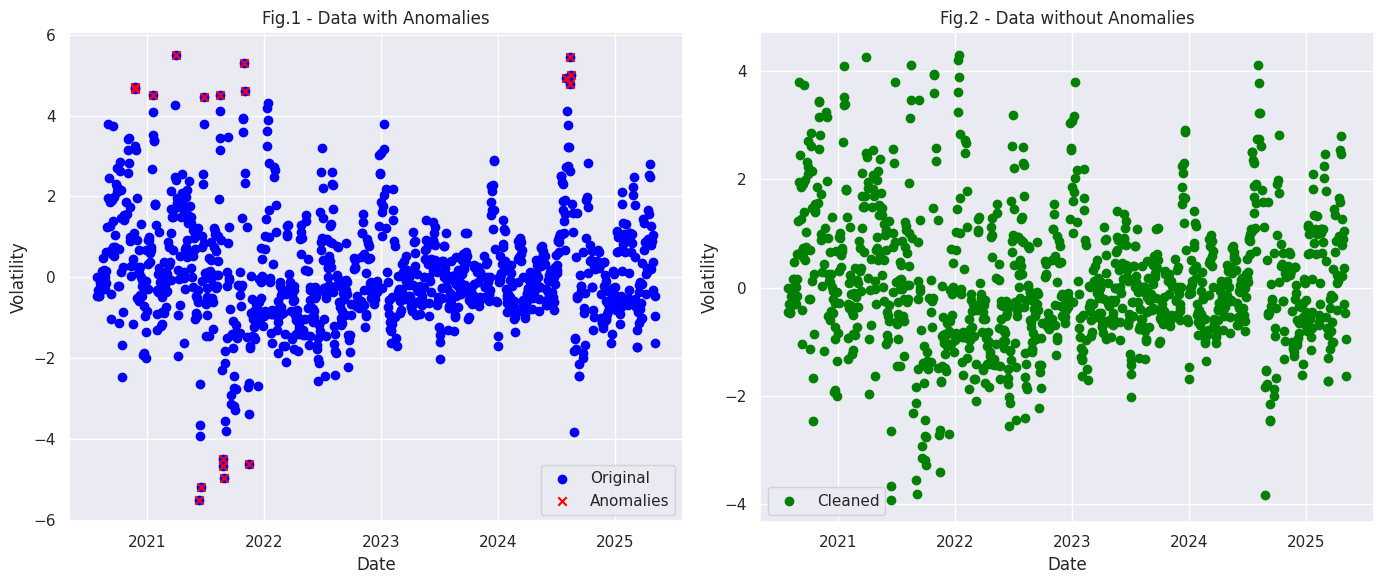

In [51]:
# Compute z-scores
z_scores = (df['Rolling_avg_5_day_return'] - df['Rolling_avg_5_day_return'].mean()) / df['Rolling_avg_5_day_return'].std()

# Set threshold (commonly 3 for 3σ)
threshold = 3
anomalies = df['Rolling_avg_5_day_return'][np.abs(z_scores) > threshold]

# Data without anomalies
df_cleaned = df[np.abs(z_scores) <= threshold]

# Convert PeriodIndex to Timestamp if necessary
x_values = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index
x_cleaned = df_cleaned.index.to_timestamp() if isinstance(df_cleaned.index, pd.PeriodIndex) else df_cleaned.index
x_anomalies = anomalies.index.to_timestamp() if isinstance(anomalies.index, pd.PeriodIndex) else anomalies.index

# Plotting
plt.figure(figsize=(14, 6))

# Plot 1: Original data (with anomalies)
plt.subplot(1, 2, 1)
plt.scatter(x_values, df['Rolling_avg_5_day_return'], c='blue', label='Original')
plt.scatter(x_anomalies, anomalies, c='red', label='Anomalies', marker='x')
plt.title('Fig.1 - Data with Anomalies')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

# Plot 2: Cleaned data (without anomalies)
plt.subplot(1, 2, 2)
plt.scatter(x_cleaned, df_cleaned['Rolling_avg_5_day_return'], c='green', label='Cleaned')
plt.title('Fig.2 - Data without Anomalies')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()


## 2. Exploratory Data Analysis (EDA)

### A. Data Visualization


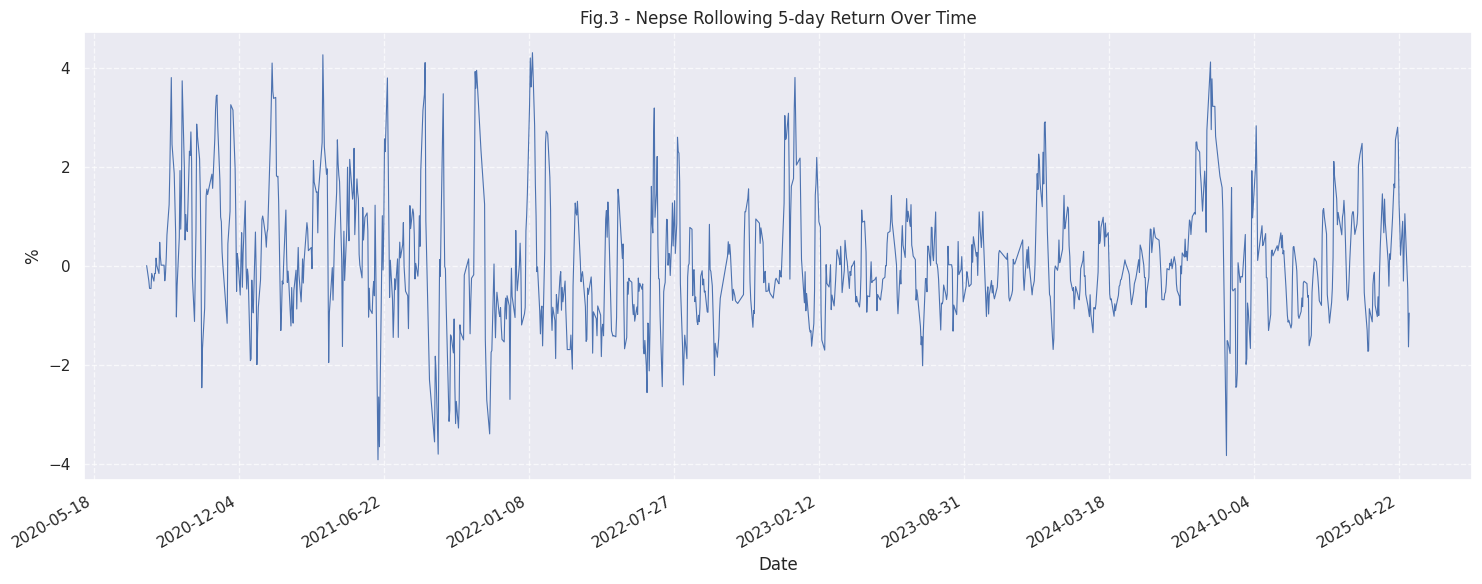

Fig.4 - Histogram & QQ Plot


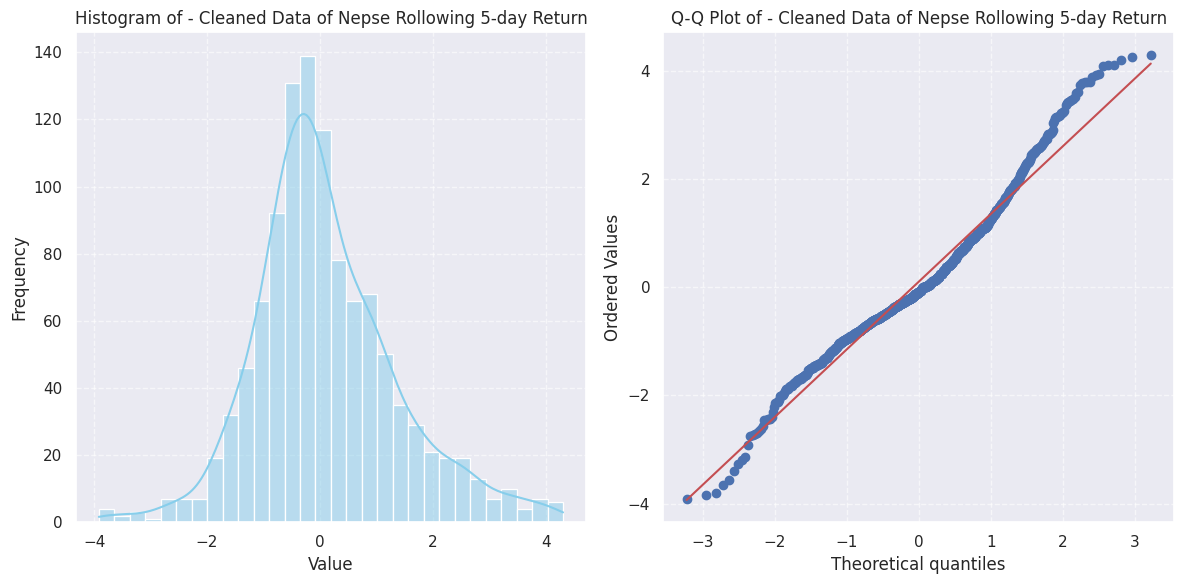

In [24]:
plot_single_plot(df_cleaned['Rolling_avg_5_day_return'], '%', 'Fig.3 - Nepse Rollowing 5-day Return Over Time')
print('Fig.4 - Histogram & QQ Plot')
plot_histogram_qq(df_cleaned['Rolling_avg_5_day_return'], title_prefix=' - Cleaned Data of Nepse Rollowing 5-day Return')

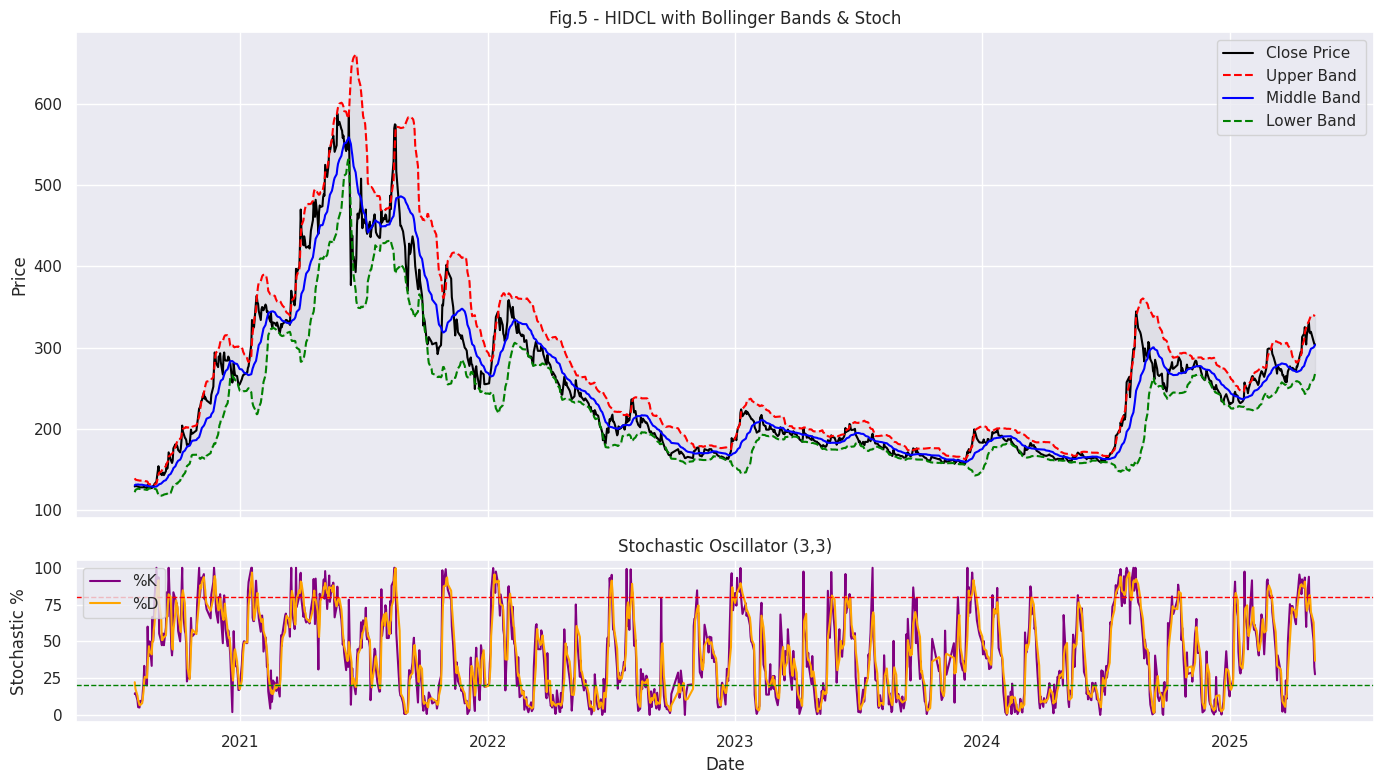

In [25]:
if isinstance(df.index, pd.PeriodIndex):
    df.index = df.index.to_timestamp()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- Upper subplot: Price + Bollinger Bands
ax1.plot(df.index, df['Close'], label='Close Price', color='black')
ax1.plot(df.index, df['bb_upper'], label='Upper Band', linestyle='--', color='red')
ax1.plot(df.index, df['bb_middle'], label='Middle Band', color='blue')
ax1.plot(df.index, df['bb_lower'], label='Lower Band', linestyle='--', color='green')
ax1.fill_between(df.index, df['bb_lower'], df['bb_upper'], color='gray', alpha=0.1)
ax1.set_title('Fig.5 - HIDCL with Bollinger Bands & Stoch')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# --- Lower subplot: Stochastic Oscillator
ax2.plot(df.index, df['stoch_k'], label='%K', color='purple')
ax2.plot(df.index, df['stoch_d'], label='%D', color='orange')
ax2.axhline(80, color='red', linestyle='--', linewidth=1)   # Overbought
ax2.axhline(20, color='green', linestyle='--', linewidth=1) # Oversold
ax2.set_title('Stochastic Oscillator (3,3)')
ax2.set_ylabel('Stochastic %')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### B. Data Statistics

In [14]:
# Calculate statistics
desc_stats = df_cleaned['Rolling_avg_5_day_return'].describe()
skew_val = skew(df_cleaned['Rolling_avg_5_day_return'])
kurtosis_val = kurtosis(df_cleaned['Rolling_avg_5_day_return'])

# Create a table-friendly list
stats_table = [
    ["Count", desc_stats['count']],
    ["Mean", desc_stats['mean']],
    ["Std", desc_stats['std']],
    ["Min", desc_stats['min']],
    ["25%", desc_stats['25%']],
    ["50%", desc_stats['50%']],
    ["75%", desc_stats['75%']],
    ["Max", desc_stats['max']],
    ["Skewness", skew_val],
    ["Kurtosis", kurtosis_val]
]

# Display the table
print(tabulate(stats_table,
               headers=["Statistic", "Value"],
               tablefmt='fancy_grid',
               stralign='center',
               numalign='center',
               floatfmt=".4f"))

╒═════════════╤═══════════╕
│  Statistic  │   Value   │
╞═════════════╪═══════════╡
│    Count    │ 1106.0000 │
├─────────────┼───────────┤
│    Mean     │  0.1025   │
├─────────────┼───────────┤
│     Std     │  1.2667   │
├─────────────┼───────────┤
│     Min     │  -3.9170  │
├─────────────┼───────────┤
│     25%     │  -0.6546  │
├─────────────┼───────────┤
│     50%     │  -0.0876  │
├─────────────┼───────────┤
│     75%     │  0.7794   │
├─────────────┼───────────┤
│     Max     │  4.3045   │
├─────────────┼───────────┤
│  Skewness   │  0.5398   │
├─────────────┼───────────┤
│  Kurtosis   │  0.9586   │
╘═════════════╧═══════════╛


## 3. Data Pre-Processing

### A. Stationarity Testing

**Intepretation:**

- ADF Statistic < Critical Value → Reject the null hypothesis → the series is stationary.

- p-value < 0.05 → Strong evidence against the null → the series is stationary.

In [26]:
# Perform the ADF test without Trend and Drift
adf(df_cleaned['Rolling_avg_5_day_return'], trend='n', method='aic')

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-6.980
P-value,0.000
Lags,18


In [27]:
# Perform the ADF test With Drift (Constant but no trend)
adf(df_cleaned['Rolling_avg_5_day_return'], trend='c', method='aic')  # Constant only

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-7.070
P-value,0.000
Lags,18


In [28]:
# Perform the ADF test With Trend and Drift
adf(df_cleaned['Rolling_avg_5_day_return'], trend='ct', method='aic')

Augmented Dickey-Fuller Unit Root Test:



Test Statistic,-7.149
P-value,0.000
Lags,18


## 4. ARIMA Model Building

### A. Plot ACF and PACF to identify AR and MA terms

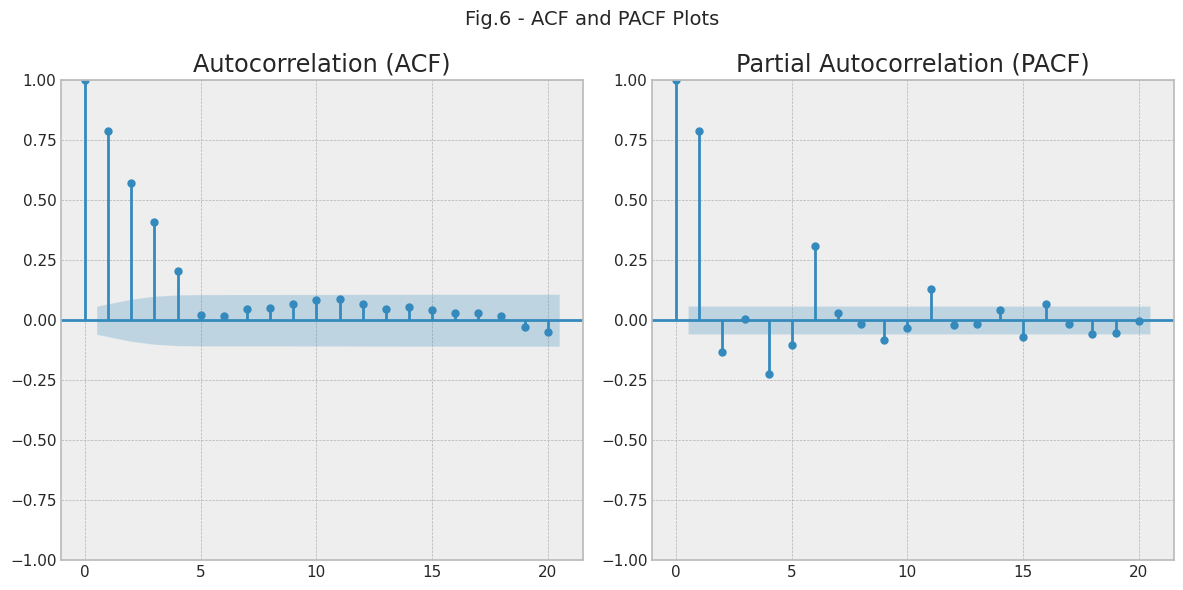

In [29]:
acf_plot(df_cleaned['Rolling_avg_5_day_return'], lags=20, figsize=(12, 6), style='bmh', title='Fig.6 - ACF and PACF Plots')

### B. Fit several ARIMA(p,d,q) models

In [52]:
# Fit the auto_arima model
model_auto_selection = auto_arima(
    df_cleaned['Rolling_avg_5_day_return'],
    start_p = 0,
    start_q = 0,
    max_p = 5,
    max_q = 5,
    information_criterion='aic',
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3669.811, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2592.185, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2955.944, Time=1.44 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2575.422, Time=1.44 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2577.375, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2573.775, Time=0.53 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2573.904, Time=0.28 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2575.762, Time=0.58 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2572.276, Time=1.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2574.764, Time=0.44 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2521.587, Time=2.61 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2424.304, Time=0.87 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2521.203, Time=0.41 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=2443.900, Time=0.72 sec
 ARIMA(4,0,3)(0,0,0)[0]          

### C. Choose the best model

In [53]:
# Fit the model with the optimal lag based on auto_arima
target = df_cleaned['Rolling_avg_5_day_return']
model_arima = ARIMA(target, order=(3, 0, 4), trend='n').fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:     Rolling_avg_5_day_return   No. Observations:                 1106
Model:                       ARIMA(3, 0, 4)   Log Likelihood               -1178.051
Date:                      Tue, 13 May 2025   AIC                           2372.103
Time:                              07:07:46   BIC                           2412.171
Sample:                          07-29-2020   HQIC                          2387.257
                               - 05-06-2025                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1021      0.047      2.162      0.031       0.010       0.195
ar.L2         -0.1452      0.054     -2.711      0.007      -0.250      -0.040
ar.L3          0.1551      0.041      3.822      0.000       0.076       0.235
ma.L1          0.7975      0.038     20.925      0.000       0.723       0.872
ma.L2          0.7884      0.041     19.279      0.000       0.708       0.869
ma.L3          0.6284      0.026     23.754      0.000       0.577       0.680
ma.L4          0.5250      0.018     28.895      0.000       0.489       0.561
sigma2         0.4918      0.012     41.905      0.000       0.469       0.515
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1867.87
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5. Forecasting HIDCL Returns Using Expanding Window Forecast

### **Step = 1**

The following code uses an ARIMA model to predict the stock return (or any time series value), one day at a time, using an expanding window approach.

  - On day 1 of the test set:

    - Train the model with the initial 80 days.

    - Forecast day 81.

  - On day 2:

    - Add day 81 to the training data.

    - Forecast day 82.

And so on…

In [54]:
# Define initial training size (e.g., 70% of the data)
train_size = int(len(target) * 0.8)
train, test = target[:train_size], target[train_size:]

# Store forecasts
forecast_list = []

# Expanding window forecast loop
for i in range(len(test)):
    train_expanding = target[:train_size + i]
    model = ARIMA(train_expanding, order=(3, 0, 4), trend='n').fit()
    forecast = model.forecast(steps=1)
    forecast_list.append(forecast[0])

# Convert forecast to Series aligned with test set
forecast_series = pd.Series(forecast_list, index=test.index)

# Evaluate the performance
mae = mean_absolute_error(test, forecast_series)
mse = mean_squared_error(test, forecast_series)
r2 = r2_score(test, forecast_series)

# Create table with tabulate
headers = ['Model', 'MSE', 'MAE', 'R2']
data = [['ARIMA(2,0,1)', mse, mae, r2]]

print(tabulate(data, headers=headers, tablefmt='fancy_grid', stralign='center', numalign='center', floatfmt=".2f"))

╒══════════════╤═══════╤═══════╤══════╕
│    Model     │  MSE  │  MAE  │  R2  │
╞══════════════╪═══════╪═══════╪══════╡
│ ARIMA(2,0,1) │ 0.38  │ 0.45  │ 0.74 │
╘══════════════╧═══════╧═══════╧══════╛


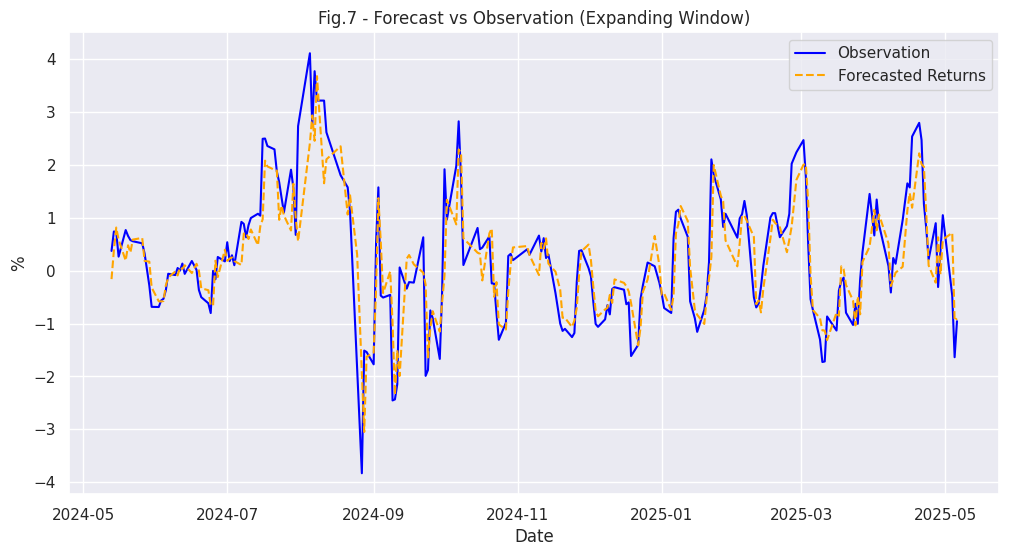

In [57]:
# Convert PeriodIndex to DatetimeIndex
test_plot = test.copy()
forecast_plot = forecast_series.copy()

test_plot.index = test_plot.index.to_timestamp()
forecast_plot.index = forecast_plot.index.to_timestamp()

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_plot, label='Observation', color='blue')
plt.plot(forecast_plot, label='Forecasted Returns', color='orange', linestyle='--')
plt.title('Fig.7 - Forecast vs Observation (Expanding Window)')
plt.xlabel('Date')
plt.ylabel('%')
plt.legend()
plt.grid(True)
plt.show()



**What Could Possibly Happen On 2025-05-07**

In [64]:
# Step 1: Forecast Direction Calculation
forecast_array = np.array(forecast_series)
direction_list = ["N/A"] + ["UP" if forecast_array[i] > forecast_array[i - 1] else "DOWN"
                            for i in range(1, len(forecast_array))]

# Step 2: Create Forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecasted_Return': forecast_array,
    'Forecast_Direction': direction_list,
    'Actual_Return': test.values
}, index=test.index)

print(forecast_df.tail(10))

# Step 3: Forecast the Next Day
future_forecast = model_arima.forecast(steps=1)

# Ensure proper future date index (daily)
last_date = test.index[-1]
future_date = last_date + pd.Timedelta(days=1)

future_df = pd.DataFrame({
    'Forecasted_Return': future_forecast.values
}, index=[future_date])

print("\nNext Day Forecast:")
print(future_df)

            Forecasted_Return Forecast_Direction  Actual_Return
Date                                                           
2025-04-22           1.967365               DOWN       1.260665
2025-04-23           1.074544               DOWN       0.797945
2025-04-24           0.100460               DOWN       0.213794
2025-04-27          -0.224842               DOWN       0.900097
2025-04-28           0.633582                 UP      -0.307664
2025-04-29          -0.065912               DOWN       0.369811
2025-04-30           0.589918                 UP       1.052112
2025-05-04           0.718770                 UP      -0.473396
2025-05-05          -0.944564               DOWN      -1.636065
2025-05-06          -0.903223                 UP      -0.954525

Next Day Forecast:
            Forecasted_Return
2025-05-07          -1.020501


## 6. Model Diagnostics & Residual Analysis

Fig.8 - ARIMA(3,0,4) Model Diagnostics:



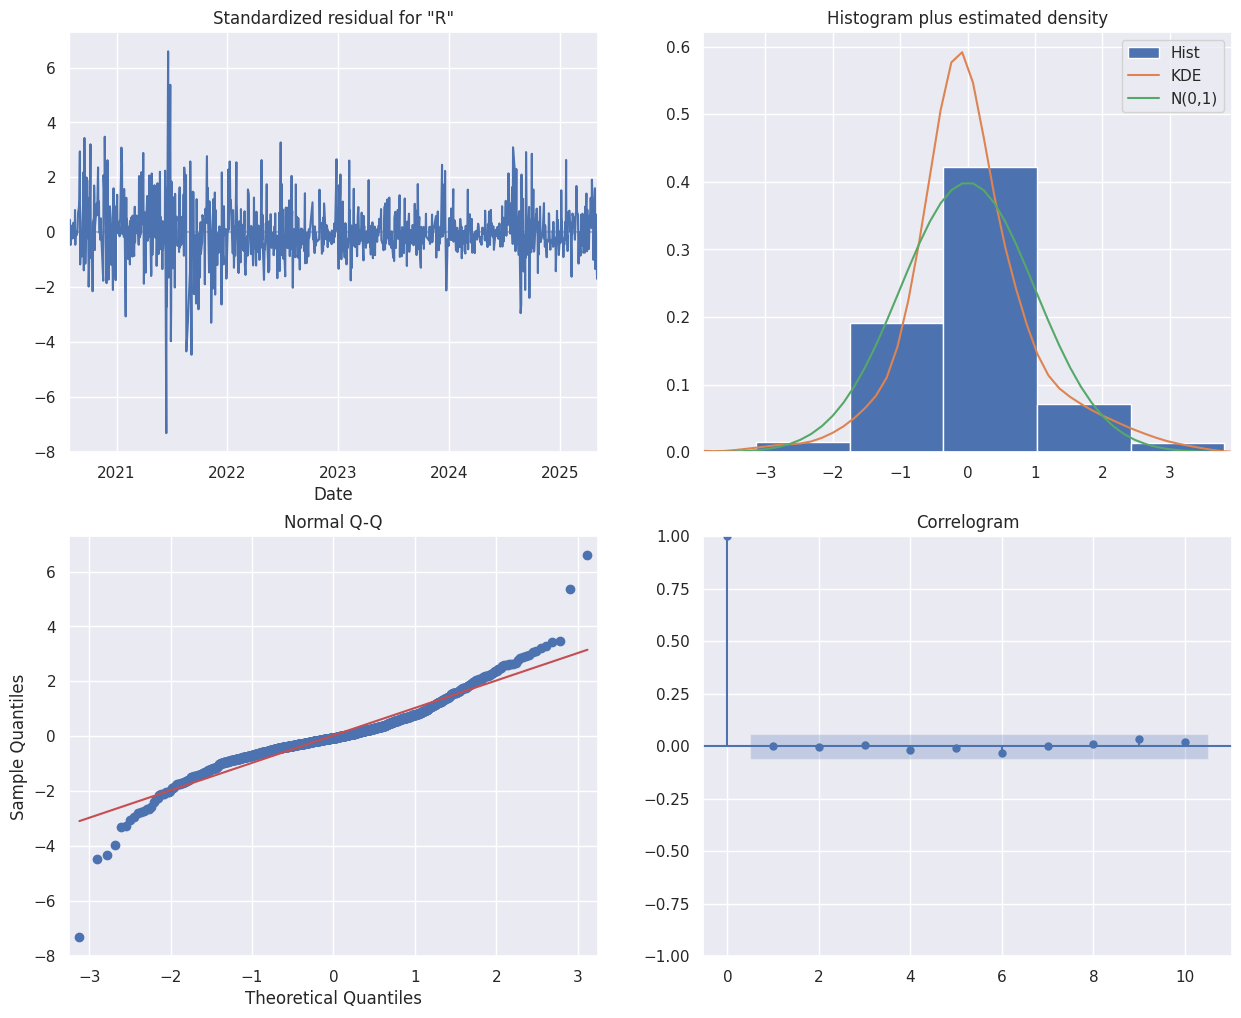

In [65]:
print('Fig.8 - ARIMA(3,0,4) Model Diagnostics:\n')
model_arima.plot_diagnostics(figsize=(15,12))
plt.show()

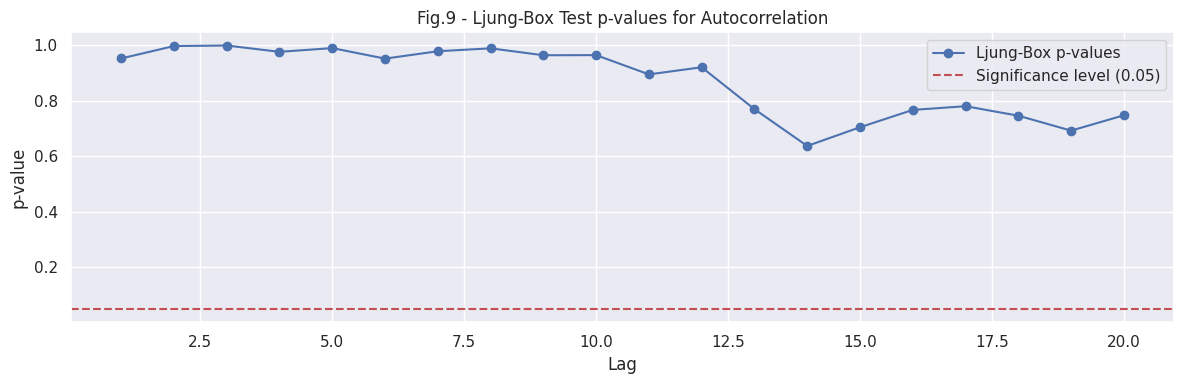

In [66]:
# Ljung-Box test
lb_test = sm.stats.diagnostic.acorr_ljungbox(model_arima.resid, lags=20, return_df=True)

# Plot p-values with reference line at alpha = 0.05
plt.figure(figsize=(12, 4))
plt.plot(lb_test.index, lb_test['lb_pvalue'], marker='o', label='Ljung-Box p-values')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (0.05)')

# Labeling
plt.title('Fig.9 - Ljung-Box Test p-values for Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()